# Bottle Anomalies Autoencoder

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os
import cv2
import random

# Training data of 1 class and Test data of several classes


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224,224)), # Unify images to (224,224) size
    transforms.ToTensor()
])

train_dir=r'C:\Users\Chinmayee BM\Desktop\CV project\train'
test_dir=r'C:\Users\Chinmayee BM\Desktop\CV project\test'

train_dataset = ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
class_names = test_dataset.classes

print(class_names)
print(len(train_dataset),len(test_dataset))

['broken_large', 'broken_small', 'contamination', 'good']
209 83


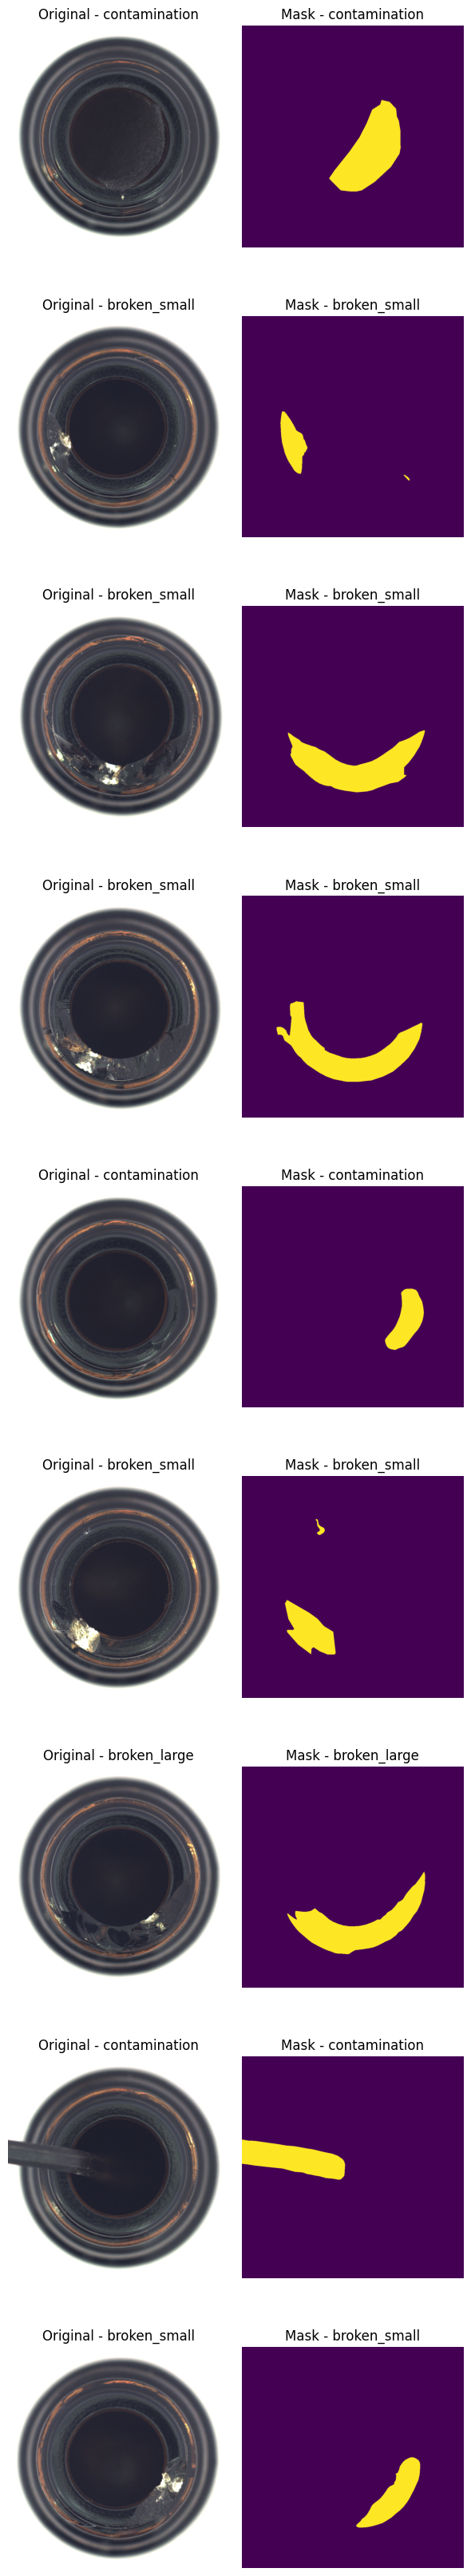

In [9]:
import os
import random
import matplotlib.pyplot as plt

# Collect 9 anomaly image paths (not 'good') that start with digit 0–4
paths = []
for dirname, _, filenames in os.walk(r'C:\Users\Chinmayee BM\Desktop\CV project\test'):
    for filename in filenames:
        if os.path.basename(dirname) != 'good' and filename[2] in list('01234'):
            paths.append(os.path.join(dirname, filename))

paths = random.sample(paths, 9)

# Path to ground truth masks
dir0 = r'C:\Users\Chinmayee BM\Desktop\CV project\ground_truth'

# Plot
fig, axs = plt.subplots(9, 2, figsize=(6, 33))

for i in range(9):
    path = paths[i]

    # Safely get label from folder name
    label = os.path.basename(os.path.dirname(path))

    # Original image
    img = plt.imread(path)
    axs[i][0].imshow(img)
    axs[i][0].set_title(f"Original - {label}")
    axs[i][0].axis("off")

    # Ground truth mask path
    filename = os.path.splitext(os.path.basename(path))[0] + '_mask.png'
    path2 = os.path.join(dir0, label, filename)

    # Ground truth mask image
    if os.path.exists(path2):
        mask_img = plt.imread(path2)
        axs[i][1].imshow(mask_img)
        axs[i][1].set_title(f"Mask - {label}")
    else:
        axs[i][1].text(0.5, 0.5, 'Mask not found', ha='center', va='center')
        axs[i][1].set_title(f"Mask - {label}")
    axs[i][1].axis("off")

plt.tight_layout()
plt.show()


In [10]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
# Instantiate Autoencoder and send to GPU
autoencoder = Autoencoder().to(device)

# Definition of loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

## Training the autoencoder


In [ ]:
# training
for epoch in range(100):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = Variable(img).to(device)
        optimizer.zero_grad()
        outputs = autoencoder(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('Epoch [%d], Loss: %.4f' % (epoch+1, running_loss/len(train_loader)))

Epoch [1], Loss: 0.3993
Epoch [2], Loss: 0.3759
Epoch [3], Loss: 0.2923
Epoch [4], Loss: 0.2127
Epoch [5], Loss: 0.1587
Epoch [6], Loss: 0.1012
Epoch [7], Loss: 0.0676
Epoch [8], Loss: 0.0497
Epoch [9], Loss: 0.0252
Epoch [10], Loss: 0.0210
Epoch [11], Loss: 0.0194
Epoch [12], Loss: 0.0186
Epoch [13], Loss: 0.0178
Epoch [14], Loss: 0.0173
Epoch [15], Loss: 0.0169
Epoch [16], Loss: 0.0164
Epoch [17], Loss: 0.0160
Epoch [18], Loss: 0.0155
Epoch [19], Loss: 0.0151
Epoch [20], Loss: 0.0147
Epoch [21], Loss: 0.0143
Epoch [22], Loss: 0.0140
Epoch [23], Loss: 0.0136
Epoch [24], Loss: 0.0133
Epoch [25], Loss: 0.0130
Epoch [26], Loss: 0.0127
Epoch [27], Loss: 0.0123
Epoch [28], Loss: 0.0121
Epoch [29], Loss: 0.0118
Epoch [30], Loss: 0.0116
Epoch [31], Loss: 0.0113
Epoch [32], Loss: 0.0110
Epoch [33], Loss: 0.0109
Epoch [34], Loss: 0.0106
Epoch [35], Loss: 0.0104
Epoch [36], Loss: 0.0101
Epoch [37], Loss: 0.0100
Epoch [38], Loss: 0.0097
Epoch [39], Loss: 0.0096
Epoch [40], Loss: 0.0094
Epoch [41

In [ ]:
# Testing
from sklearn.metrics import classification_report
autoencoder.eval()
for criteria in [0.001,0.003,0.01,0.03,0.1]:
    y_pred=[]
    y_true=[]
    test_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            img, label = data
            img = Variable(img).to(device)
            outputs = autoencoder(img)
            loss = criterion(outputs, img)
            test_loss += loss.item()
            for i in range(len(img)):
                lossi=criterion(outputs[i], img[i])
                y_pred+=[int(lossi.item()>criteria)] #ture(big loss)=1,false(smsll loss)=0
                y_true+=[int(label[i]>0)] #ture(not notmal)=1,false(normal)=0
    print('test_loss',test_loss)
    print('criteria: lossi.item()>',criteria)
    print(classification_report(y_true, y_pred, target_names=['Normal','Abnormal'], digits=4))

test_loss 0.03486591810360551
criteria: lossi.item()> 0.001
              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000        20
    Abnormal     0.7590    1.0000    0.8630        63

    accuracy                         0.7590        83
   macro avg     0.3795    0.5000    0.4315        83
weighted avg     0.5761    0.7590    0.6551        83



e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test_loss 0.03486591810360551
criteria: lossi.item()> 0.003
              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000        20
    Abnormal     0.7590    1.0000    0.8630        63

    accuracy                         0.7590        83
   macro avg     0.3795    0.5000    0.4315        83
weighted avg     0.5761    0.7590    0.6551        83



e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test_loss 0.03486591810360551
criteria: lossi.item()> 0.01
              precision    recall  f1-score   support

      Normal     0.2410    1.0000    0.3883        20
    Abnormal     0.0000    0.0000    0.0000        63

    accuracy                         0.2410        83
   macro avg     0.1205    0.5000    0.1942        83
weighted avg     0.0581    0.2410    0.0936        83



e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test_loss 0.03486591810360551
criteria: lossi.item()> 0.03
              precision    recall  f1-score   support

      Normal     0.2410    1.0000    0.3883        20
    Abnormal     0.0000    0.0000    0.0000        63

    accuracy                         0.2410        83
   macro avg     0.1205    0.5000    0.1942        83
weighted avg     0.0581    0.2410    0.0936        83



e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test_loss 0.03486591810360551
criteria: lossi.item()> 0.1
              precision    recall  f1-score   support

      Normal     0.2410    1.0000    0.3883        20
    Abnormal     0.0000    0.0000    0.0000        63

    accuracy                         0.2410        83
   macro avg     0.1205    0.5000    0.1942        83
weighted avg     0.0581    0.2410    0.0936        83



e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Udemy\Python\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# comparing classes in test data
autoencoder.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
class_encodings = [[] for i in range(6)]
with torch.no_grad():
    for data in test_loader:
        img, label = data
        img = Variable(img).to(device)
        encoding = autoencoder.encoder(img)
        class_encodings[label.item()].append(encoding.cpu().numpy().ravel())

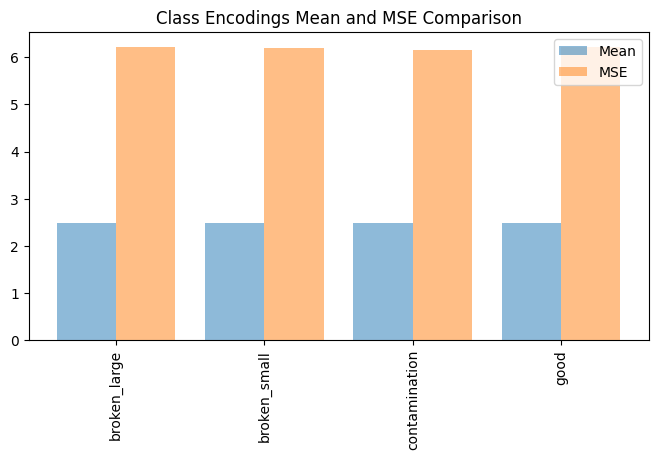

In [ ]:
class_means = []
class_mses = []
for i in range(4):
    class_means.append(np.mean(class_encodings[i]))
    class_mse = np.mean((class_encodings[i] - class_means[i])**2)
    class_mses.append(class_mse)

plt.figure(figsize=(8,4))
plt.bar(np.arange(4)-0.2, class_means, width=0.4, label='Mean', alpha=0.5)
plt.bar(np.arange(4)+0.2, class_mses, width=0.4, label='MSE', alpha=0.5)
plt.xticks(range(4), class_names, rotation=90)
plt.legend()
plt.title("Class Encodings Mean and MSE Comparison")
plt.show()

In [12]:
# Save the model's state dict
torch.save(autoencoder.state_dict(), "bottle_autoencoder.pth")


In [13]:
torch.save(autoencoder, "bottle_autoencoder_full.pth")


In [22]:
! pip install streamlit
import streamlit as st
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from sklearn.metrics import confusion_matrix, auc, roc_curve
import pandas as pd

# ---------- Autoencoder Definition (Must match training) ----------
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# ---------- Load Model ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
model.load_state_dict(torch.load("bottle_autoencoder.pth", map_location=device))
model.eval()

# ---------- Utilities ----------
def load_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def preprocess_image(img):
    transform = transforms.ToTensor()
    return transform(img).unsqueeze(0)

def calculate_iou(gt, pred, threshold=0.5):
    gt_bin = (gt > threshold).astype(np.uint8)
    pred_bin = (pred > threshold).astype(np.uint8)
    intersection = np.logical_and(gt_bin, pred_bin).sum()
    union = np.logical_or(gt_bin, pred_bin).sum()
    return intersection / union if union != 0 else 0

# ---------- Streamlit UI ----------
st.title("🔍 Bottle Anomaly Detection using Autoencoder")

img_path = st.text_input("Enter path to test image:", "/content/drive/MyDrive/bottle/test/image.png")

results = []

if img_path and os.path.exists(img_path):
    # Load & preprocess
    original = load_image(img_path)
    input_tensor = preprocess_image(original).to(device)

    # Reconstruct
    with torch.no_grad():
        reconstructed = model(input_tensor).cpu().squeeze().permute(1, 2, 0).numpy()

    # Error map
    error_map = np.abs(original / 255.0 - reconstructed)
    reconstruction_error = np.mean(error_map)
    error_percent = reconstruction_error * 100

    # IoU - if GT available (placeholder for now)
    iou = calculate_iou(original / 255.0, reconstructed)

    # AUE - Area under error map
    fpr, tpr, _ = roc_curve((original / 255.0).flatten(), reconstructed.flatten())
    area_under_error = auc(fpr, tpr)

    # Append results
    results.append({
        "Image": os.path.basename(img_path),
        "Error %": round(error_percent, 4),
        "IoU": round(iou, 4),
        "AUE": round(area_under_error, 4)
    })

    # Display
    col1, col2 = st.columns(2)
    with col1:
        st.image(original, caption="Original", use_column_width=True)
    with col2:
        st.image(reconstructed, caption="Reconstructed", use_column_width=True)

    st.subheader("📊 Results")
    st.write(f"**Reconstruction Error (%):** {error_percent:.2f}%")
    st.write(f"**IoU:** {iou:.4f}")
    st.write(f"**AUE (Area Under Error):** {area_under_error:.4f}")

    # Heatmap
    st.subheader("🔍 Anomaly Heatmap")
    fig, ax = plt.subplots()
    ax.imshow(np.mean(error_map, axis=2), cmap='hot')
    ax.axis('off')
    st.pyplot(fig)

    # Export CSV
    st.subheader("📁 Export Results")
    df = pd.DataFrame(results)
    csv = df.to_csv(index=False).encode('utf-8')
    st.download_button("Download CSV", data=csv, file_name="results.csv", mime="text/csv")
else:
    st.info("Please enter a valid image path from the dataset.")

2025-04-12 22:35:23.744 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 22:35:23.810 
  command:

    streamlit run e:\Udemy\Python\venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-04-12 22:35:23.811 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 22:35:23.812 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 22:35:23.812 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 22:35:23.813 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 22:35:23.813 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 22:35:23.813 Session state does not func